In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(), # from 0~255 to 0~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # from 0~1 to -1~1 (v - mean) / std
])

In [59]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [60]:
len(trainset), len(testset)

(50000, 10000)

In [61]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available.')

cuda is available.


In [63]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net = Net().to(device)

In [64]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [66]:
loss_ = []
n = len(train_loader)
net.train()

for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, labels = data[0].to(device), data[1].to(device)
        preds = net(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_.append(running_loss/n)
    print(f'[{epoch+1}] loss: {running_loss/n:.3f}')

print('Finished Training')

[1] loss: 1.849
[2] loss: 1.474
[3] loss: 1.338
[4] loss: 1.244
[5] loss: 1.171
[6] loss: 1.109
[7] loss: 1.052
[8] loss: 1.008
[9] loss: 0.963
[10] loss: 0.925
Finished Training


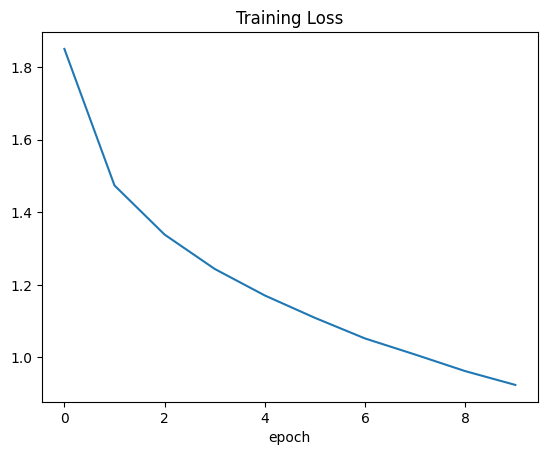

In [67]:
plt.plot(loss_)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
PATH = 'models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [69]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [70]:
correct = 0
total = 0

with torch.inference_mode():
    net.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, pred = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (pred == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 63.21 %
